# Week autoencoder encoding

This notebook trains an autoencoder to create a fixed length vector encoding for an epiweek (without the year). The data used is for all the regions and over all seasons.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../../src/")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import data

from keras.layers import (Activation, Convolution1D, Convolution2D, Dense,
                          Dropout, Embedding, Flatten, Merge)
from keras.models import Sequential
from keras.regularizers import l2

from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split

## Load and split data

In [4]:
adl = data.ActualDataLoader("../../data")
index, wili = adl.get()

In [5]:
X = (index["epiweek"] % 100).values
y = wili

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [11]:
print(f"Week numbers: {X_train}")
print(f"Wili: {y_train}")

Week numbers: [51 40 22 ..., 28 48  8]
Wili: [ 2.50760628  6.98577912  0.497772   ...,  0.17059535  0.69157946
  3.1036324 ]


## The model

A very simplistic model. Nothing fancy, just predicts _wili_ after encoding the week numbers. Could probably be useless if the role of actual week input is not important.

In [15]:
def week_embedding(embedding_size):
    """
    Learn embedding matrix for weeks using week number as input and wili
    as output

    Parameters
    ----------
    embedding_size : int
        Embedding vector size for week
    """

    model = Sequential()

    model.add(Embedding(54, embedding_size, input_length=1))
    model.add(Flatten())
    model.add(Activation("relu"))
    model.add(Dense(10))
    model.add(Activation("relu"))
    model.add(Dense(1))

    return model

model = week_embedding(5)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1, 5)              270       
_________________________________________________________________
flatten_2 (Flatten)          (None, 5)                 0         
_________________________________________________________________
activation_3 (Activation)    (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                60        
_________________________________________________________________
activation_4 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer="adam", loss="mse")

In [17]:
history = model.fit(X_train, y_train,
                    batch_size=64, epochs=20,
                    verbose=0,
                    validation_data=(X_test, y_test))

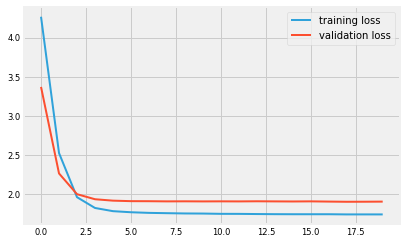

In [18]:
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()

In [19]:
model.evaluate(X_test, y_test)

  32/2057 [..............................] - ETA: 0s

1.9019895661323465

In [20]:
emb = model.layers[0].weights[0].get_value()

## Predictions

Predictions from the model vs actual wili values.

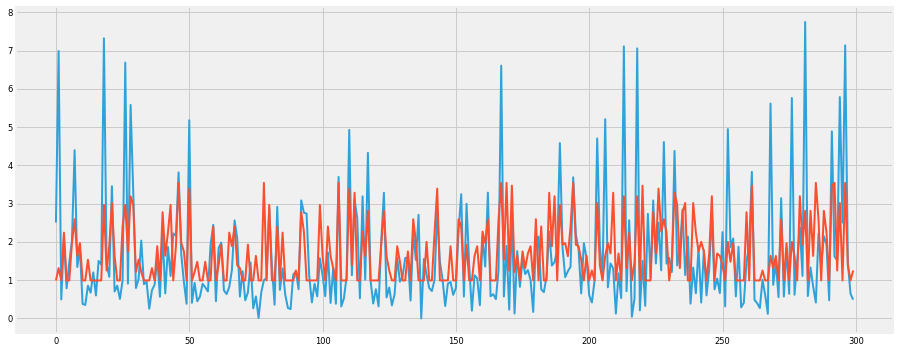

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(y_train[:300])
plt.plot(model.predict(X_train)[:300])

## Components of encoding

The plot below shows how the value of each of the _encoding-size_ numbers change over the epiweek

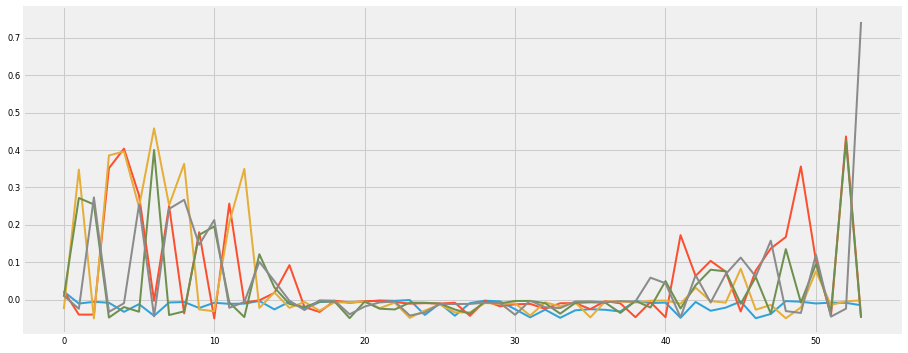

In [22]:
plt.figure(figsize=(14, 6))
for i in range(emb.shape[1]):
    plt.plot(emb[:, i])

## Average values

Plot below shows the average value of wili for each epiweek. This can work as a simple model to encode information about current week in the ensemble models.

In [23]:
from keras.utils.np_utils import to_categorical

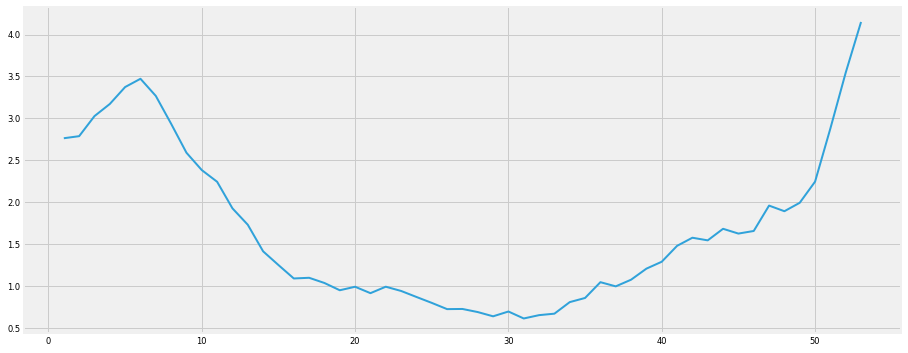

In [24]:
plt.figure(figsize=(14, 6))
plt.plot(to_categorical(X_train).T.dot(y_train) / to_categorical(X_train).sum(axis=0))